This tutorial describes how to build and configure a single-node Hadoop system. Some of the material for this tutorial is take from the [Apache Hadoop Documentation](https://hadoop.apache.org/docs/current/index.html). The tutorial should take approximately 1 hour to complete. You do not have to complete it in one sitting, however. The 1 hour time includes time for downloading Hadoop from Apache mirror servers, which may vary depending on your internet connection. 

The tutorial has been written in a way such that all of the commands work out of the box. However, if a particular command does not work on your system or you get a weird error message, please add your question to the discussion forum. 

Since most real-world Hadoop systems are installed on Linux servers, this tutorial covers the installation steps on Linux-based system. In particular, the tutorial is written for [Ubuntu 18.04 or later](https://releases.ubuntu.com/18.04/). To complete the tutorial you will need access to a Linux system with root privileges. If you don't have one you can check the steps for installing a Linux VM on a Windows PC. You will also need some basic familariaty with the Linux command-line. If you have not used the command-line before, I recommend learning basic commands from one of the myriad Linux tutorials out there. 


The main steps for setting up your own Hadoop cluster are listed below. 

   1. [Getting Ready](#getting_ready)
   2. [Download and Installation](#download)
   3. [Configuration](#config)
   4. [Formatting namenode](#format)
   5. [Running and Testing](#running)
   6. [Conclusion](#end)




## <a name="getting_ready"></a> Getting Ready 

Before we can install the Hadoop cluster, we need to ensure we have all the required software. Log into you Linux system using an account that has sudo access. 


### Packages 

First, we need to ensure that your system is up-to-date with with all the latest Ubuntu packages. Use the following command to update your system before initiating a new installation:

`sudo apt update`

### Java 

The Hadoop framework is written in Java, and its services require a compatible Java Runtime Environment (JRE) and Java Development Kit (JDK). For Hadoop to work correctly, we need a relatively newere version of Java. .  Check the version of java installed.

In [10]:
!javac -version 

javac 1.8.0_312


In [9]:
!java -version 

openjdk version "11.0.14.1" 2022-02-08
OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


If you get a command not found error or the output shows that `javac < 1.8` or `OpenJDK JRE < 11` then you will need to install Java. If you have a recent version of Java installeed you can skip to the next step of `ssh` installation. 

We can use the apt package manager to install a newer version of Java with the following command. You will need sudo for this as the installation will be system-wide. 

In [4]:
!sudo apt install openjdk-8-jdk-headless -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  openjdk-8-demo openjdk-8-source
The following NEW packages will be installed:
  openjdk-8-jdk-headless
0 upgraded, 1 newly installed, 0 to remove and 92 not upgraded.
Need to get 8,298 kB of archives.
After this operation, 39.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.04 [8,298 kB]
Fetched 8,298 kB in 2s (4,906 kB/s)                 3m

78Selecting previously unselected package openjdk-8-jdk-headless:amd64.
(Reading database ... 205750 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jdk-headless_8u312-b07-0ubuntu1~18.04_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 17%] [#########.................................................] 8Unpacking openjdk-8-jdk-h

Now, let's make sure we have the right version of Java. 

In [10]:
!javac -version 

javac 1.8.0_312


In [9]:
!java -version 

openjdk version "11.0.14.1" 2022-02-08
OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


### Secure Shell 

Hadoop will use secture shell (`ssh`) to comminacte between nodes. You should already have `ssh` installed on your system. In case you don't, install the latest openssh on your system with the following command.

In [12]:
!sudo apt install openssh-server openssh-client -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  openssh-sftp-server
Suggested packages:
  keychain libpam-ssh monkeysphere ssh-askpass molly-guard rssh
The following packages will be upgraded:
  openssh-client openssh-server openssh-sftp-server
3 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.
Need to get 988 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 openssh-sftp-server amd64 1:7.6p1-4ubuntu0.7 [45.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 openssh-server amd64 1:7.6p1-4ubuntu0.7 [332 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 openssh-client amd64 1:7.6p1-4ubuntu0.7 [610 kB]
Fetched 988 kB in 1s (730 kB/s)         
Preconfiguring packages ...

(Reading database ... 205858 files and directories currently installed.)


### Hadoop User

If you are going to be using Hadoop extensively, you should create a separate Hadoop user with controlled priveleges. This step is optional but recommended for security reasons. The Hadoop user will be responsible for launching the Hadoop daemons and the HDFS files will reside in this users home paritition. You can choose any for the user but the user must have sudo access (to install Hadoop). 

We will create a user with id `zeus` and provide sudo access.  

`sudo adduser zeus`
`sudo usermod -aG zeus`

Now switch to the new user 

`ssh zeus@localhost`

### Password-less ssh

Hadoop will use automated scripts to communicate between nodes. To avoid typing the password everytime you can set up password-less ssh. Don't worry, this is a secure operation since only the Hadoop user will be able to login without a password _within_ your system.  

To set up password-less, we first need to generate a pair of public and private keys. You can do so with the following command.  

`ssh-keygen -t rsa -P '' -f ~/.ssh/id_rsa`

Now add the newly generated key to the authorized_keys file. 

`cat ~/.ssh/id_rsa.pub >> ~/.ssh/authorized_keys`

Change the permission so that only the user `zeus` can view it.

`chmod 0600 ~/.ssh/authorized_keys`

Now, check to see if it worked. 

`ssh localhost`

You should be in a new login for zeus on your machine without having to type in your password. 

## <a name="download"></a>Download and Install Hadoop 

You will need to download Hadoop from the [Apache Mirror server](https://dlcdn.apache.org/hadoop/common/). To download version 3.3.1, use the following command 

`wget https://dlcdn.apache.org/hadoop/common/hadoop-3.3.1/hadoop-3.3.1.tar.gz`

Now untar and unzip the archive. 

`tar zxvf hadoop-3.3.1.tar.gz`

The command should take a few seconds to run and you should see lots of output on the screend. If the untar command completed successfuly, the Hadoop binaries and libraries should now be in the `hadoop-3.3.1` directory. Check to see if the binaries are indeed there. 

`ls hadoop-3.3.1/bin`

Right now, the installation of Hadoop is in the local directory of the user `zeus`. It's a good idea to move it to a system location. To move it to a system location you need `sudo` access. We have already added `zeus` to the sudoers list. Now we can move the Hadoop installation to a system location with a `sudo`. I will move it to `/usr/local` which is a standard place installing many software. 

`sudo mv hadoop-3.3.1 /usr/local/` 

## <a name="config"></a>Configuration 

Hadoop is now installed on your system. But before we can run it we need to modify some configuration files. We will need to modify one file in the user space and three files in the Hadoop space. 


### User-level 

The user's shell configuration file (.bashrc in this case) must the know the location of the Hadoop installation. To provide this information edit the `.bashrc` file in the users home directory and enter the following. The `.bashrc` will likely have some other content. You can put the Hadoop definitions at the very end of the file. 

```bash
export HADOOP_HOME=/usr/local/hadoop-3.3.1
export HADOOP_INSTALL=$HADOOP_HOME
export HADOOP_MAPRED_HOME=$HADOOP_HOME
export HADOOP_COMMON_HOME=$HADOOP_HOME
export HADOOP_HDFS_HOME=$HADOOP_HOME
export YARN_HOME=$HADOOP_HOME
export HADOOP_COMMON_LIB_NATIVE_DIR=$HADOOP_HOME/lib/native
export PATH=$PATH:$HADOOP_HOME/sbin:$HADOOP_HOME/bin
export HADOOP_OPTS="-Djava.library.path=$HADOOP_HOME/lib/native"
```

Mainly you just need to specify the top-level Hadoop directory. All the other locations is derived relative to that path. The top-level directory in this example is `/usr/local/hadoop-3.3.1`. If you have installed Hadoop in a different location then you want to specify that directory. 

### System-level 

#### Hadoop environement 

We need to configure the Hadoop ennvironment so that it can find the correct version of Java. Let's re-check the version of Java and its location on your system.  

In [2]:
!which javac

/usr/bin/javac


The above tells you the location of the Java compiler. But on Linux systems this is typically set-up as a symbolic link. To get the _actual_ location of Java use the following command. 

In [3]:
!readlink -f /usr/bin/javac

/usr/lib/jvm/java-8-openjdk-amd64/bin/javac


Now edit the `hadoop-env.sh` file and add the appropriate Java path. Open the file in your favorite Linux editor. Note, you will need to open with `sudo` to save the modified file in the system location.  


```bash
sudo emacs -nw /usr/local/hadoop-3.3.1/etc/hadoop/hadoop-env.sh
```

`hadoop-env.sh` should have a line `export JAVA_HOME=` which may be commented out. Uncomment the line and the Java path after the `=`  

```
export JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64/bin/javac
```

#### Hadoop core

We need to tell Hadoop where to store temporary files and also the url for the Hadoop file system. In this example, we will use `tmpdata` as the location of the temporary files. Since we are doing a pseudo-distributed installation, we will set the location of the file system to be just the localhost (127.0.0.1). 

This changes will neeed to be made in `core` configuration file which is in `xml` format. Open the core-site.xml in your editer and copy-paste the content below. 

```bash
sudo emacs -nw /usr/local/hadoop-3.3.1/etc/hadoop/core-site.xml
```

```xml
<property>
  <name>hadoop.tmp.dir</name>
  <value>/home/zeus/tmpdata</value>
</property>
<property>
  <name>fs.default.name</name>
  <value>hdfs://127.0.0.1:9000</value>
</property>
```


Of course, if you want to use a different `tmp` location then you will change the above xml code accoprdingly. Make sure that the temporary directory exists in the specified location.  

#### HDFS

For the HDFS, we need to tell Haddoop the location of the Namenode and DataNode (discussed in Module 2, Section 1.2). 
Edit the HDFS configuration file and copy-paste the following xml code excerpt. 

```bash
sudo emacs -nw /usr/local/hadoop-3.3.1/etc/hadoop/hdfs-site.xml
```

```xml
<property>
  <name>dfs.data.dir</name>
  <value>/home/zeus/dfsdata/namenode</value>
</property>
<property>
  <name>dfs.data.dir</name>
  <value>/home/zeus/dfsdata/datanode</value>
</property>
<property>
  <name>dfs.replication</name>
  <value>1</value>
</property>
```

#### MapReduce

We need to let Hadoop know that we will be using YARN for MapReduce resource manager (discussed in Module 2, Section 1.3). Edit the file mapred-site.xml

```bash
sudo emacs -nw /usr/local/hadoop-3.3.1/etc/hadoop/mapred-site.xml
```

Copy-paste the following XML code excerpt. 

```xml
<property> 
  <name>mapreduce.framework.name</name> 
  <value>yarn</value> 
</property>
```

#### YARN

Finally, we need to configure YARN and let it know which libaries to use when managing resources for MapReduce jobs. Edit the yarn-site.xml file 

```bash
sudo emacs -nw /usr/local/hadoop-3.3.1/etc/hadoop/mapred-site.xml
```

Copy-paste the following XML code excerpt. 

```xml
<property>
  <name>yarn.nodemanager.aux-services</name>
  <value>mapreduce_shuffle</value>
</property>
<property>
  <name>yarn.nodemanager.aux-services.mapreduce.shuffle.class</name>
  <value>org.apache.hadoop.mapred.ShuffleHandler</value>
</property>
<property>
  <name>yarn.resourcemanager.hostname</name>
  <value>127.0.0.1</value>
</property>
<property>
  <name>yarn.acl.enable</name>
  <value>0</value>
</property>
<property>
  <name>yarn.nodemanager.env-whitelist</name>     <value>JAVA_HOME,HADOOP_COMMON_HOME,HADOOP_HDFS_HOME,HADOOP_CONF_DIR,CLASSPATH_PERPEND_DISTCACHE,HADOOP_YARN_HOME,HADOOP_MAPRED_HOME</value>
</property>
```

The above settings are the default options for YARN. You can customize it other parameters. Do figure out all the customization optiona look at the [Apache documentation on YARN](https://hadoop.apache.org/docs/stable/hadoop-yarn/hadoop-yarn-site/YARN.html)


### <a name="format"></a>Formatting the `namenode` 

Now, we have Hadoop installed and configured. There is one more step before we can run the Hadoop cluster. The `namenode` must be fortmatted with `hdfs`. This is not the same as formatting or re-formatting a hard disk. This just ensure that the `namenode` has all the information to work with the target hard disk.  

`hdfs namenode -format`

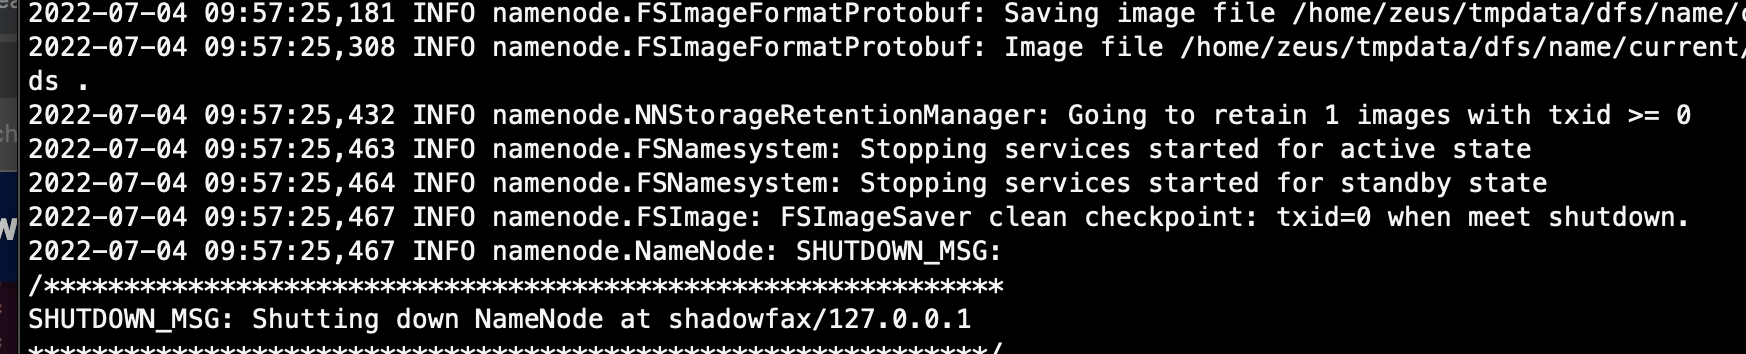

## <a name="running"></a>Running and Testing 

At this stage, we should be all set to run the Hadoop single-node cluster. To start the cluster, we need to invoke a script that is the in Hadoop sbin directory. 

```bash
/usr/local/hadoop-3.3.1/sbin/start-dfs.sh
```


Now start YARN

```bash
/usr/local/hadoop-3.3.1/sbin/start-yarn.sh
```


Now run a simple check to make sure everything is running. 

`jps`

## <a name="end"></a>Conclusion

That's it! You now have a working Hadoop cluster in pseudo-distribution mode. 